In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from prepare import clean_diabetic_data, data_split, select_kbest, rfe
from acquire import get_diabetic_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression 
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', 80)

In [2]:
df=clean_diabetic_data()

In [3]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test =  data_split(df, stratify_by='time_in_hospital')

In [4]:
train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((1712, 62),
 (735, 62),
 (612, 62),
 (1712, 56),
 (1712,),
 (735, 56),
 (735,),
 (612, 56),
 (612,))

In [5]:
train.head()

,race,gender,age,weight,time_in_hospital,insulin,race_AfricanAmerican,race_Asian,race_Caucasian,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight_>200,weight_[0-25),weight_[100-125),weight_[125-150),weight_[150-175),weight_[175-200),weight_[25-50),weight_[50-75),weight_[75-100),metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Steady,repaglinide_Up,nateglinide_Steady,nateglinide_Up,chlorpropamide_Steady,glimepiride_Down,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_Down,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Steady,acarbose_Up,tolazamide_Steady,insulin_Down,insulin_Steady,insulin_Up
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67220310,Caucasian,Male,[80-90),[50-75),6,No,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
373698290,Caucasian,Female,[70-80),[50-75),3,No,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
121404990,Caucasian,Male,[70-80),[75-100),3,No,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
108540414,Caucasian,Female,[60-70),[75-100),6,No,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46492332,Caucasian,Female,[70-80),[75-100),2,Steady,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


##### Hypothesis Testing #1 (ANOVA)
$H_0$: There is no difference in length of hospital stay between each race.

$H_a$: There is a significant difference in length of hospital stay based on race.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [6]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = " there is no difference in length of hospital stay between each race."

In [7]:
F, p = stats.f_oneway(train.time_in_hospital[train.race_AfricanAmerican == 1], train.time_in_hospital[train.race_Asian == 1], train.time_in_hospital[train.race_Caucasian == 1], train.time_in_hospital[train.race_Other == 1])
F, p

(0.3835495297503344, 0.7648757086166358)

In [8]:
if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that  there is no difference in length of hospital stay between each race.


Text(0.5, 1.0, 'Race v. Time in Hospital')

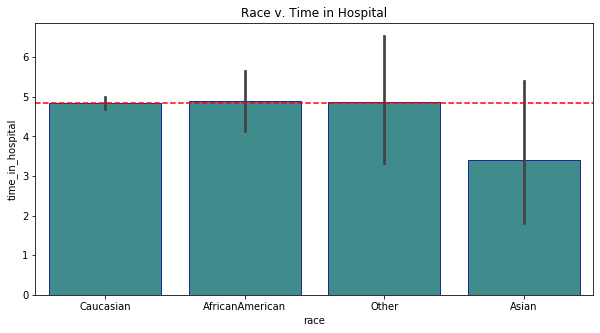

In [9]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.race, train.time_in_hospital, data=train, alpha=.8, color='teal', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Race v. Time in Hospital')

#### Hypothesis Testing #2 (ANOVA)
$H_0$: There is no difference in length of hospital stay between when changing insulin dose.

$H_a$: There is a significant difference in length of hospital stay when insulin dosage is increased.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [10]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = 'there is no difference in length of hospital stay between when changing insulin dose.'

In [11]:
F, p = stats.f_oneway(train.time_in_hospital[train.insulin_Down == 1], train.time_in_hospital[train.insulin_Up == 1], train.time_in_hospital[train.insulin_Steady== 1])
F, p

(1.9649100210567043, 0.1412713784906219)

In [12]:
if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that there is no difference in length of hospital stay between when changing insulin dose.


Text(0.5, 1.0, 'Insulin Dosage v. Time in Hospital')

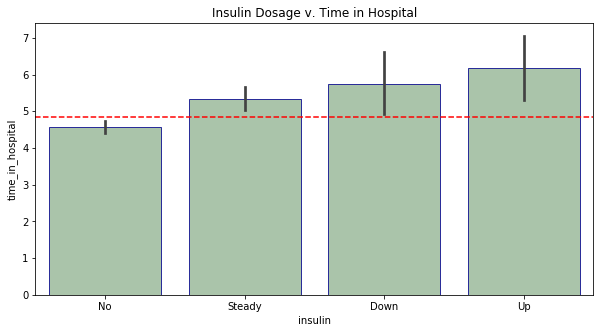

In [13]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.insulin, train.time_in_hospital, data=train, alpha=.8, color='darkseagreen', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Insulin Dosage v. Time in Hospital')

Text(0.5, 1.0, 'Age v. Time in Hospital')

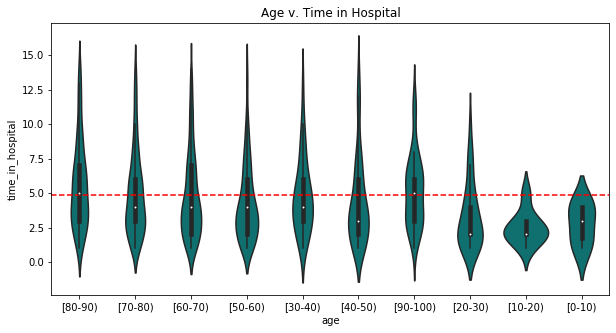

In [14]:
p = plt.figure(figsize=(10,5))
p = sns.violinplot(train.age, train.time_in_hospital, data=train, alpha=.8, color='teal', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Age v. Time in Hospital')

Text(0.5, 1.0, 'Weight v. Time in Hospital')

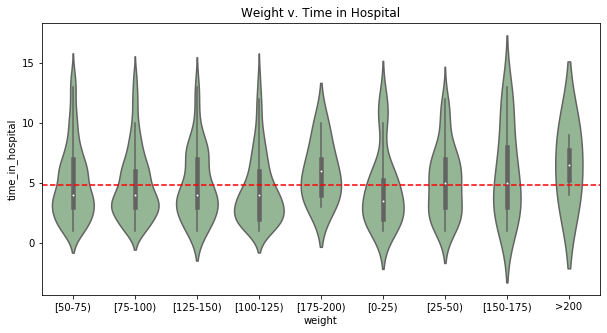

In [15]:
p = plt.figure(figsize=(10,5))
p = sns.violinplot(train.weight, train.time_in_hospital, data=train, alpha=.8, color='DarkSeaGreen', edgecolor = 'darkblue')
overall_rate = train.time_in_hospital.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Weight v. Time in Hospital')

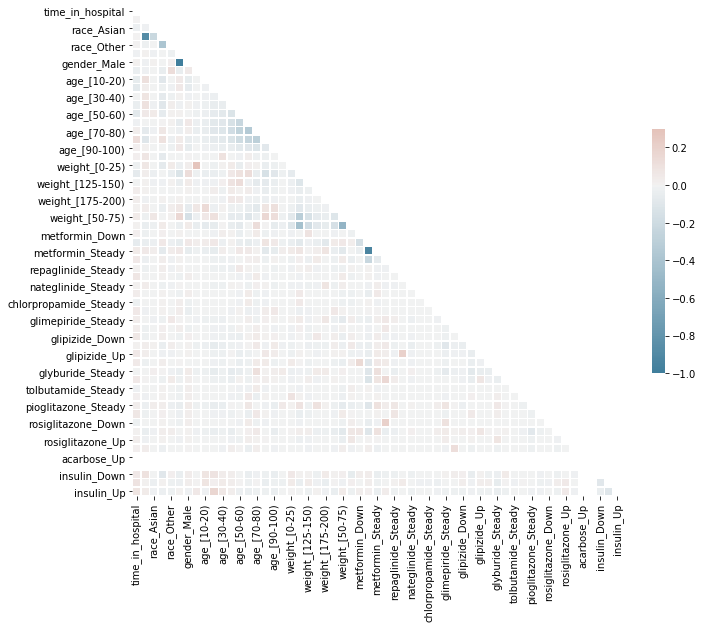

In [16]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
train.columns

Index(['race', 'gender', 'age', 'weight', 'time_in_hospital', 'insulin',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Other',
       'gender_Female', 'gender_Male', 'age_[0-10)', 'age_[10-20)',
       'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)',
       'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)',
       'weight_>200', 'weight_[0-25)', 'weight_[100-125)', 'weight_[125-150)',
       'weight_[150-175)', 'weight_[175-200)', 'weight_[25-50)',
       'weight_[50-75)', 'weight_[75-100)', 'metformin_Down', 'metformin_No',
       'metformin_Steady', 'metformin_Up', 'repaglinide_Steady',
       'repaglinide_Up', 'nateglinide_Steady', 'nateglinide_Up',
       'chlorpropamide_Steady', 'glimepiride_Down', 'glimepiride_Steady',
       'glimepiride_Up', 'glipizide_Down', 'glipizide_Steady', 'glipizide_Up',
       'glyburide_Down', 'glyburide_Steady', 'glyburide_Up',
       'tolbutamide_Steady', 'pioglitazone_Down', 'pioglitazone_Steady',
       '

# Clustering

In [18]:
np.random.seed(123)

### Cluster on Metformin Columns

In [19]:
X1 = X_train[['metformin_Down', 'metformin_Steady', 'metformin_Up']]
X2 = X_validate[['metformin_Down', 'metformin_Steady', 'metformin_Up']]
X3 = X_test[['metformin_Down', 'metformin_Steady', 'metformin_Up']]

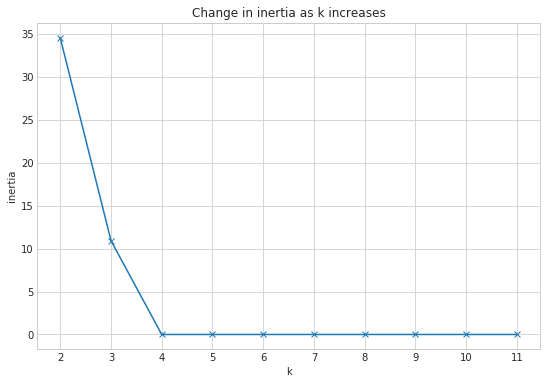

In [20]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [21]:
# Make the kmeans object
kmeans = KMeans(n_clusters=2)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [22]:
X_train['cluster_metformin'] = kmeans.predict(X1)
X_validate['cluster_metformin'] = kmeans.predict(X2)
X_test['cluster_metformin'] = kmeans.predict(X3)

### Cluster on Melgitinides

In [23]:
X4 = X_train[['repaglinide_Steady', 'repaglinide_Up', 'nateglinide_Steady', 'nateglinide_Up', ]]
X5 = X_validate[['repaglinide_Steady', 'repaglinide_Up', 'nateglinide_Steady', 'nateglinide_Up']]
X6 = X_test[['repaglinide_Steady', 'repaglinide_Up', 'nateglinide_Steady', 'nateglinide_Up']]

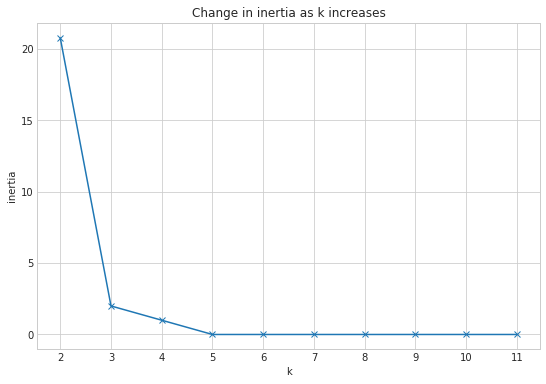

In [24]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X4).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [25]:
# Make the kmeans object
kmeans = KMeans(n_clusters=2)

# fit the kmeans model
kmeans.fit(X4)

# use the thing
kmeans.predict(X4)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [26]:
X_train['cluster_Melgitinides'] = kmeans.predict(X4)
X_validate['cluster_Melgitinides'] = kmeans.predict(X5)
X_test['cluster_Melgitinides'] = kmeans.predict(X6)

### Cluster on sulfonylureas

In [27]:
X7 = X_train[['tolazamide_Steady','chlorpropamide_Steady', 'glimepiride_Down', 'glimepiride_Steady', 'glimepiride_Up','glipizide_Down', 'glipizide_Steady', 'glipizide_Up','glyburide_Down', 'glyburide_Steady', 'glyburide_Up', 'tolbutamide_Steady']]
X8 = X_validate[['tolazamide_Steady','chlorpropamide_Steady', 'glimepiride_Down', 'glimepiride_Steady', 'glimepiride_Up','glipizide_Down', 'glipizide_Steady', 'glipizide_Up','glyburide_Down', 'glyburide_Steady', 'glyburide_Up', 'tolbutamide_Steady']]
X9 = X_test[['tolazamide_Steady','chlorpropamide_Steady', 'glimepiride_Down', 'glimepiride_Steady', 'glimepiride_Up','glipizide_Down', 'glipizide_Steady', 'glipizide_Up','glyburide_Down', 'glyburide_Steady', 'glyburide_Up', 'tolbutamide_Steady']]

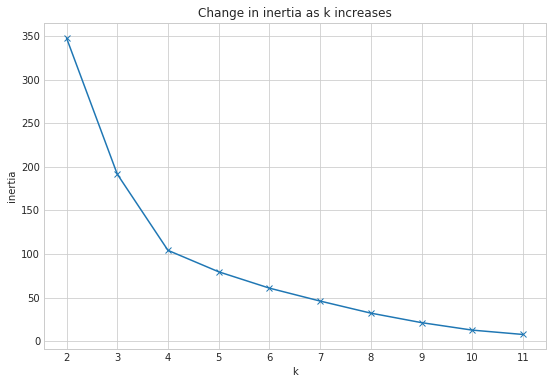

In [28]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X7).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [29]:
# Make the kmeans object
kmeans = KMeans(n_clusters=3)

# fit the kmeans model
kmeans.fit(X7)

# use the thing
kmeans.predict(X7)


array([0, 1, 2, ..., 2, 0, 0], dtype=int32)

In [30]:
X_train['cluster_sulfonylureas'] = kmeans.predict(X7)
X_validate['cluster_sulfonylureas'] = kmeans.predict(X8)
X_test['cluster_sulfonylureas'] = kmeans.predict(X9)

### Cluster on Thiazolidinedione-type

In [31]:
X10= X_train[['pioglitazone_Down', 'pioglitazone_Steady', 'pioglitazone_Up','rosiglitazone_Down', 'rosiglitazone_Steady','rosiglitazone_Up']]
X11= X_validate[['pioglitazone_Down', 'pioglitazone_Steady', 'pioglitazone_Up','rosiglitazone_Down', 'rosiglitazone_Steady','rosiglitazone_Up']]
X12= X_test[['pioglitazone_Down', 'pioglitazone_Steady', 'pioglitazone_Up','rosiglitazone_Down', 'rosiglitazone_Steady','rosiglitazone_Up']]

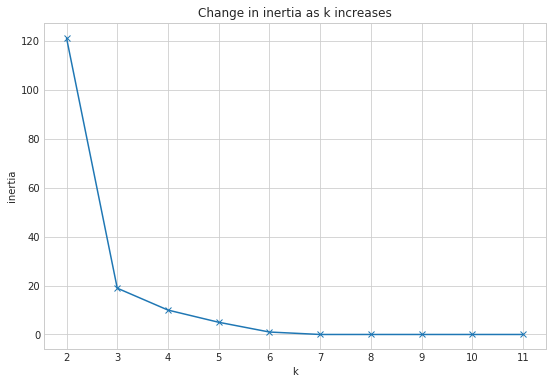

In [32]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X10).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [33]:
# Make the kmeans object
kmeans = KMeans(n_clusters=3)

# fit the kmeans model
kmeans.fit(X10)

# use the thing
kmeans.predict(X10)

array([0, 0, 2, ..., 1, 0, 0], dtype=int32)

In [34]:
X_train['cluster_t_types'] = kmeans.predict(X10)
X_validate['cluster_t_types'] = kmeans.predict(X11)
X_test['cluster_t_types'] = kmeans.predict(X12)

### Cluster on Alpha-glucosidase inhibitors

In [35]:
X13= X_train[['acarbose_Steady', 'acarbose_Up']]
X14= X_validate[['acarbose_Steady', 'acarbose_Up']]
X15= X_test[['acarbose_Steady', 'acarbose_Up']]

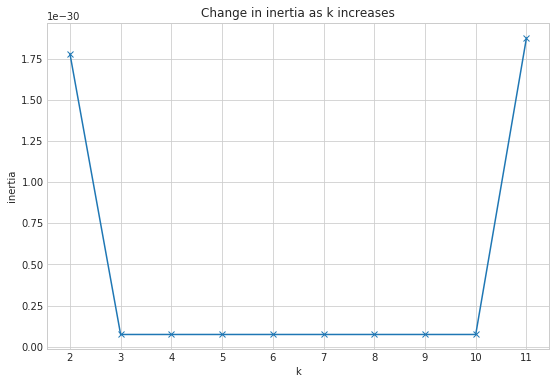

In [36]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X13).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [37]:
# Make the kmeans object
kmeans = KMeans(n_clusters=2)

# fit the kmeans model
kmeans.fit(X13)

# use the thing
kmeans.predict(X13)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [38]:
X_train['cluster_agi'] = kmeans.predict(X13)
X_validate['cluster_agi'] = kmeans.predict(X14)
X_test['cluster_agi'] = kmeans.predict(X15)

### Cluster on Insulin

In [39]:
X16= X_train[['insulin_Down','insulin_Steady', 'insulin_Up']]
X17= X_validate[['insulin_Down','insulin_Steady', 'insulin_Up']]
X18= X_test[['insulin_Down','insulin_Steady', 'insulin_Up']]

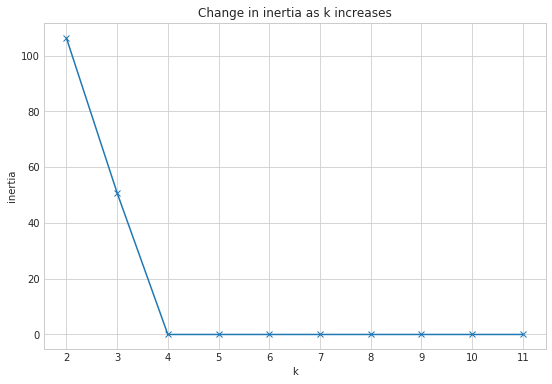

In [40]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X16).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [41]:
# Make the kmeans object
kmeans = KMeans(n_clusters=2)

# fit the kmeans model
kmeans.fit(X16)

# use the thing
kmeans.predict(X16)

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [42]:
X_train['cluster_insulin'] = kmeans.predict(X16)
X_validate['cluster_insulin'] = kmeans.predict(X17)
X_test['cluster_insulin'] = kmeans.predict(X18)

### Cluster on Demographics

In [43]:
X19= X_train[['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Other',
       'gender_Female', 'gender_Male']]
X20= X_validate[['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Other',
       'gender_Female', 'gender_Male']]
X21= X_test[['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Other',
       'gender_Female', 'gender_Male']]

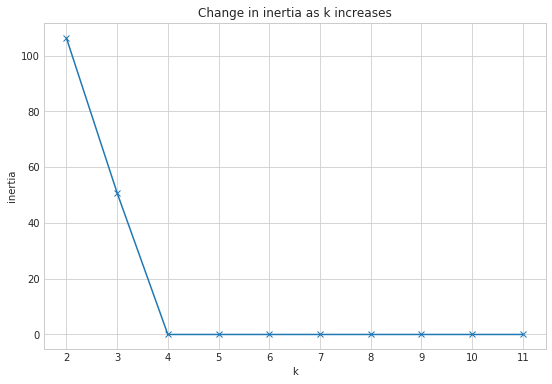

In [44]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X16).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [45]:
# Make the kmeans object
kmeans = KMeans(n_clusters=3)

# fit the kmeans model
kmeans.fit(X19)

# use the thing
kmeans.predict(X19)

array([2, 1, 2, ..., 2, 2, 2], dtype=int32)

In [46]:
X_train['cluster_demographics'] = kmeans.predict(X19)
X_validate['cluster_demographics'] = kmeans.predict(X20)
X_test['cluster_demographics'] = kmeans.predict(X21)
train['cluster_demographics'] = kmeans.predict(X19)

### Cluster on Age and Weight

In [47]:
X22= X_train[['age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)',
       'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)',
       'weight_>200', 'weight_[0-25)', 'weight_[100-125)', 'weight_[125-150)',
       'weight_[150-175)', 'weight_[175-200)', 'weight_[25-50)','weight_[50-75)', 'weight_[75-100)']]
X23= X_validate[['age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)',
       'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)',
       'weight_>200', 'weight_[0-25)', 'weight_[100-125)', 'weight_[125-150)',
       'weight_[150-175)', 'weight_[175-200)', 'weight_[25-50)','weight_[50-75)', 'weight_[75-100)']]
X24= X_test[['age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)',
       'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)',
       'weight_>200', 'weight_[0-25)', 'weight_[100-125)', 'weight_[125-150)',
       'weight_[150-175)', 'weight_[175-200)', 'weight_[25-50)','weight_[50-75)', 'weight_[75-100)']]

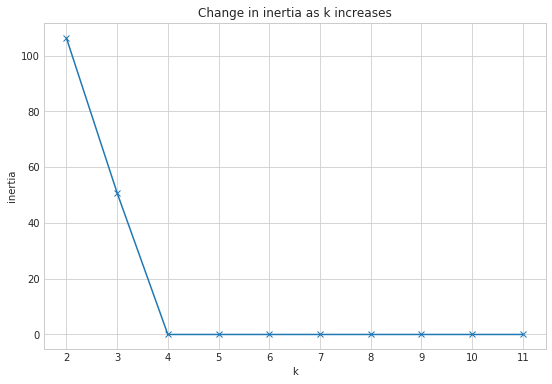

In [48]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X16).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [49]:
# Make the kmeans object
kmeans = KMeans(n_clusters=3)

# fit the kmeans model
kmeans.fit(X22)

# use the thing
kmeans.predict(X22)

array([2, 2, 1, ..., 1, 1, 1], dtype=int32)

In [50]:
X_train['cluster_age_weight'] = kmeans.predict(X22)
X_validate['cluster_age_weight'] = kmeans.predict(X23)
X_test['cluster_age_weight'] = kmeans.predict(X24)

Hypothesis Test: <br>
$H_0$: patients have the same length of stay in each  cluster.

$H_a$: patients in cluster_demographic have a higher length of stay.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [51]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = "patients have the same length of stay in each demographic cluster."

In [52]:
x1 = train[train.cluster_demographics == 1].time_in_hospital
x2 = train[train.cluster_demographics != 1].time_in_hospital

t, p= stats.ttest_ind(x1, x2)

if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that patients have the same length of stay in each demographic cluster.


Takeaways:
Most clusters have between 2-3 clusters according to the change in intertia
Demographics doesn't seem to be a driver of hospital length of stay


## Modeling

### Feature Engineering

In [53]:
skb_features = select_kbest(X_train, y_train, 5)
skb_features

['age_[50-60)',
 'age_[80-90)',
 'insulin_Steady',
 'insulin_Up',
 'cluster_insulin']

In [54]:
get_rfe = rfe(X_train, y_train, 5)
get_rfe

['age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'weight_>200', 'metformin_Up']

### Create a baseline model

In [55]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [56]:
# 1. Predict length of hospital stay mean
los_pred_mean = y_train.time_in_hospital.mean()
y_train['los_pred_mean'] = los_pred_mean
y_validate['los_pred_mean'] = los_pred_mean

# 2. compute length of hospital stay median
los_pred_median = y_train.time_in_hospital.median()
y_train['los_pred_median'] = los_pred_median
y_validate['los_pred_median'] = los_pred_median

# 3. RMSE of length of hospital stay mean
rmse_train = mean_squared_error(y_train.time_in_hospital, y_train.los_pred_mean) ** (1/2)
rmse_validate = mean_squared_error(y_validate.time_in_hospital, y_validate.los_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

# 4. RMSE of length of hospital stay median
rmse_train = mean_squared_error(y_train.time_in_hospital, y_train.los_pred_median) ** (1/2)
rmse_validate_baseline = mean_squared_error(y_validate.time_in_hospital, y_validate.los_pred_median) ** (1/2)
print("RMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate_baseline)


RMSE using Mean
Train/In-Sample:  3.0297909583445666 
Validate/Out-of-Sample:  2.9395301825497584
RMSE using Median
Train/In-Sample:  3.1432876116171413 
Validate/Out-of-Sample:  3.059278292909847


In [57]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.time_in_hospital, y_validate.los_pred_mean)}])
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,2.93953,0.0


### Linear Regression Model (OLS Regressor)

In [58]:
# Creating dataframe of cluster_insulin for modeling
X_train_cl1 = pd.DataFrame(X_train.cluster_insulin)
X_validate_cl1 = pd.DataFrame(X_validate.cluster_insulin)
X_test_cl1 = pd.DataFrame(X_test.cluster_insulin)

In [59]:
#make the thing
lm = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

lm.fit(X_train_cl1, y_train.time_in_hospital)

# predict train
# 
# use the thing!
# 
y_train['los_pred_lm'] = lm.predict(X_train_cl1)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.time_in_hospital, y_train.los_pred_lm) ** (1/2)

# predict validate
y_validate['los_pred_lm'] = lm.predict(X_validate_cl1)

# evaluate: rmse
rmse_validate_ols = mean_squared_error(y_validate.time_in_hospital, y_validate.los_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  3.017635561185686 
Validation/Out-of-Sample:  2.9187667985859322


In [60]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_ols,
    'r^2_validate': explained_variance_score(y_validate.time_in_hospital, y_validate.los_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,2.939530,0.0000
1,OLS Regressor,2.918767,0.0141


### Lasso + LARS

In [61]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_cl1, y_train.time_in_hospital)

# predict train
y_train['los_pred_lars'] = lars.predict(X_train_cl1)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.time_in_hospital, y_train.los_pred_lars) ** (1/2)

# predict validate
y_validate['los_pred_lars'] = lars.predict(X_validate_cl1)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.time_in_hospital, y_validate.los_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  3.0297909583445666 
Validation/Out-of-Sample:  2.9395301825497584


In [62]:
metric_df = metric_df.append({
    'model': 'Lasso LARS', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.time_in_hospital, y_validate.los_pred_lars)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,2.939530,0.0000
1,OLS Regressor,2.918767,0.0141
2,Lasso LARS,2.939530,0.0000


### Tweedie Regressor (GLM) Model

In [63]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_cl1, y_train.time_in_hospital)

# predict train
y_train['los_pred_glm'] = glm.predict(X_train_cl1)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.time_in_hospital, y_train.los_pred_glm) ** (1/2)

# predict validate
y_validate['los_pred_glm'] = glm.predict(X_validate_cl1)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_train.time_in_hospital, y_train.los_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  3.0176355611864825 
Validation/Out-of-Sample:  3.0176355611864825


In [64]:
metric_df = metric_df.append({
    'model': 'GLM', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.time_in_hospital, y_validate.los_pred_glm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,2.939530,0.0000
1,OLS Regressor,2.918767,0.0141
2,Lasso LARS,2.939530,0.0000
3,GLM,3.017636,0.0141


Takeaways:
- The best performing model was the OLS regressor
- I was unable to fit the polynomial regressor to the data
- The worst performing odel was the Tweedie Regressor

### Model on Test Data

In [72]:
# predict on test
y_test['los_pred_lm'] = lm.predict(X_test_cl1)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.time_in_hospital, y_test.los_pred_lm) ** (1/2)

print("RMSE for Model using \nOut-of-Sample Performance: ", rmse_test)

RMSE for Model using 
Out-of-Sample Performance:  2.897228547394784


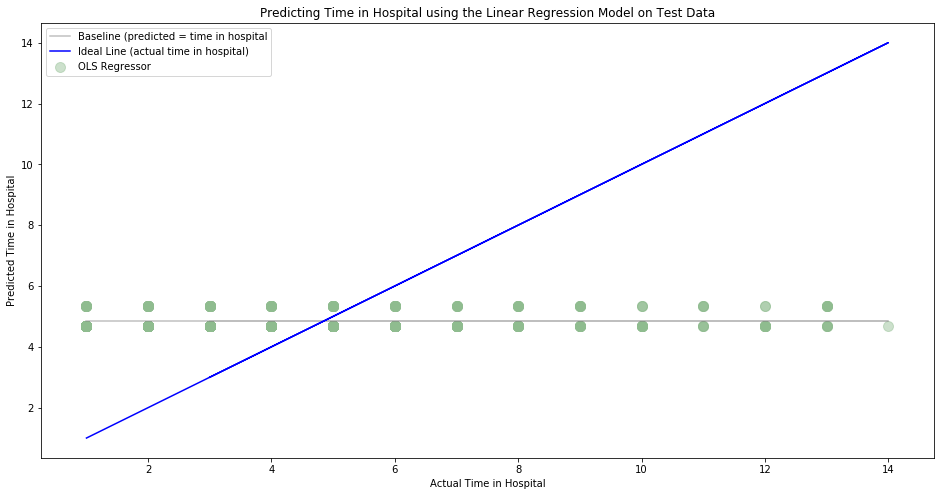

In [75]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.time_in_hospital, y_validate.los_pred_mean, alpha=.5, color="gray", label='Baseline (predicted = time in hospital')
plt.plot(y_validate.time_in_hospital, y_validate.time_in_hospital, alpha=.999, color="blue", label='Ideal Line (actual time in hospital)')

plt.scatter(y_test.time_in_hospital, y_test.los_pred_lm, 
            alpha=.45, color="darkseagreen", s=100, label="OLS Regressor")
plt.legend()
plt.xlabel("Actual Time in Hospital")
plt.ylabel("Predicted Time in Hospital")
plt.title("Predicting Time in Hospital using the Linear Regression Model on Test Data")
plt.show()

# Conclusion

- The clusters on insulin were the only clusters selected as best features by Select K Best and RFE.
- This can be evidenced by insulins being listed as top features for predicting hospital stay.
- When fitting this cluster to regression models, the best performing model is the linear regression model performed at 2.918 beating the baseline of 2.939.
- If more time was allotted, I would like to identify what demographic of patients within the insulin clusters had a increased length of stay. I would also like to compare pediatric versus adult length of stays.
- If more resources were alloted, I would like to use medication compliance and if the patient had documented diabetes education prior to admission.